# **Job Placement Predictor**

**Submitted by Group 33**  
- Ashmit Gupta  
- Jolin Lin  
- Shikha Rajesh  14573562
- Siddhanth Duggal  
- Yu Chang 47945050

**The University of British Columbia**  
**STAT 301**  
**Instructor**: Dr. Gabriela Cohen Freue  
**Date**: 2025/04/10


# 1. Introduction

Landing a job soon after graduation is a top priority for most college students, yet it remains an increasingly difficult topic to achieve in a competitive market. Even among the top-performing students, slight differences—such as just one difference in the number of internship experience or the of extracurricular activities can significantly influence placement outcomes. A student who boasts a stellar GPA but lacks hands-on industry experience or meaningful extracurricular activities involvement may find themselves at a disadvantage when competing against peers who have accrued practical skills, leadership roles, or professional contacts through additional internships and clubs.

 Companies often collect data on factors such as academic performance, internships, and extracurricular activities—factors that may help predict whether a student ultimately secures employment. Building on prior work suggesting that certain behavioral and academic indicators correlate with successful job searches (Kim et al., 2022), we seek to analyze this observational data in a predictive, rather than causal, framework.

Our primary goal and expectation is to answer the question: **How effectively can we develop a predictive model to classify a student’s placement status based on their relevant academic activities, performance metrics, and other associated scores?**

By focusing on prediction, we aim to identify patterns and red flags that might be used by career advisors and students themselves, without claiming that any one factor directly causes better or worse placement outcomes. This approach aligns with our available data and the methods covered in UBC STAT 301, giving us a feasible path to explore how these factors may collectively shape students’ employment prospects.


![Alt Text](image.png)

# 2. Methods and Results

### a) Data

#### Data Description 
The dataset contains information relating to various factors that affect students' placements. More specifically, it contains information relating to their academic performance (CGPA, aptitude, SSC marks, HSC marks), training (internships, projects, workshops, soft skills), and placement (training, status). We can utilise the above variables to examine which qualities/factors most influence placement decisions. Notably, it has the following features:

- Number of variables: 12
- Number of observations: 10,000
- Variable Information: Included in the following table

| Column Name                  | Description                                                                                                                   | Data Type | Variable Type   |
|-----------------------------|-------------------------------------------------------------------------------------------------------------------------------|-----------|-----------------|
| `StudentID`                 | A unique identifier for each student (1 - 10000).                                                                             | double    | Categorical*    |
| `CGPA`                      | Overall cumulative grades achieved by a student (0 - 10 scale).                                                               | double    | Quantitative    |
| `Internships`               | Number of internships a student has completed.                                                                                | double    | Quantitative    |
| `Projects`                  | Number of projects a student has completed.                                                                                   | double    | Quantitative    |
| `Workshops/Certifications` | Number of online workshops/certifications a student has completed to upskill.                                                 | double    | Quantitative    |
| `AptitudeTestScore`         | A student's aptitude test score to gauge quantitative and logical thinking (0 - 100).                                         | double    | Quantitative    |
| `SoftSkillsRating`          | A student's communication/soft skill rating (1 - 5 scale).                                                                    | double    | Quantitative    |
| `ExtracurricularActivities` | Whether a student participates in extracurricular activities (Yes/No).                                                        | character | Categorical     |
| `PlacementTraining`         | Whether a student has undergone placement training to ace the placement process (Yes/No).                                     | character | Categorical     |
| `SSC_Marks`                 | A student's Senior Secondary Certificate marks (0 - 100).                                                                     | double    | Quantitative    |
| `HSC_Marks`                 | A student's Higher Secondary Certificate marks (0 - 100).                                                                     | double    | Quantitative    |
| `PlacementStatus`           | Placement outcome (target column with two classes: Placed/Not placed).                                                        | character | Categorical     |


 * Although StudentID is numeric in nature, it is categorical in this context.


#### Data Source and Citation
The dataset has been taken from Kaggle (https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data) updated 2 months ago by Kaggle username 'ruchikakumbhar'. It is under the 'CC0: Public Domain' License so the Kaggle user does not endorse this dataset. This also means it is freely available for us to use. The data collection method is not provided in the author's profile nor on the Kaggle dataset webpage, so we would assume it's **observational data**. The citation is as follows:

Kumbhar, R. (n.d.). *Placement Prediction Dataset*. Kaggle. Retrieved from [https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data](https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data)

#### Data Loading

In [17]:
# install.packages("readr")
# install.packages("knitr") 
# install.packages("dplyr")
# install.packages("broom")
# install.packages("corrr")
# install.packages("car")
# install.packages("tidyverse")
# install.packages("readr")
# install.packages("gridExtra")
# install.packages("leaps")
# install.packages("corrplot")
# install.packages("caret")

#Loading Libs
library(readr)
library(knitr)
library(dplyr)
library(broom)
library(corrr)
library(car)
library(tidyverse)
library(ggplot2)
library(gridExtra)
library(leaps)
library(corrplot)
library(RColorBrewer)
library(dplyr)
library(caret)
library(tibble)
library(forcats)
library(pROC)

In [18]:
data_file_link <- "https://raw.githubusercontent.com/rainn72/Placement_predictor/refs/heads/main/data/placementdata.csv"
data <- read_csv(data_file_link, show_col_types = FALSE)

original_data <- data
num_observations <- nrow(data)
num_variables <- ncol(data)
cat("Number of observations:", num_observations, "\n")
cat("Number of variables:", num_variables, "\n")

Number of observations: 10000 
Number of variables: 12 


#### Initial Data Preprocessing

1. we checked if there're duplicated values in the dataset and there are no duplicates that we need to remove.

In [19]:
duplicate_values <- data %>% 
                    group_by(StudentID) %>% 
                    summarise(value_count = n()) %>%
                    filter(value_count > 1)
                    
duplicate_values

StudentID,value_count
<dbl>,<int>


2. We dropped the variable `StudentID` from out dataset with the following reasons:

* **No Predictive Power:** It is simply a unique identifier assigned to each observation (each student). It's not correlated with the student's academic performance. Therefore, it does not help the model distinguish between students who are placed and those who are not.
* **Simplicity and Clarity:** Excluding irrelevant variables like IDs keeps our dataset cleaner and our model more interpretable.


In [20]:
data <- data %>% select(-StudentID)

3. We changed the name of a covariate because it("/") may raise errors in some following code

In [21]:
names(data)[names(data) == "Workshops/Certifications"] <- "Workshops_Certifications" 

head(data, 3)

unique(data$Workshops_Certifications)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>
7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced


[1] 1 2 0 3

4. We replaced the levels `NotPlaced` and `Placed` for `PlacementStatus` in the dataset with the numerical values `1` and `0`

In [22]:
data <- data %>%
  mutate(PlacementStatus = if_else(PlacementStatus == "Placed", 1, 0))

data$PlacementStatus <- factor(data$PlacementStatus,
                                 levels = c("0", "1"))

5. Convert the Yes/No columns (categorical) to factors and later we will 0-1 encode them for interpretability, and we treat the covariates like `Internships` or `projects` as numeric, which assumes a linear effect between each 'level'.

In [23]:
data$ExtracurricularActivities <- factor(data$ExtracurricularActivities,
                                         levels = c("No", "Yes"))
data$PlacementTraining <- factor(data$PlacementTraining,
                                 levels = c("No", "Yes"))
head(data,3)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.5,1,1,1,65,4.4,No,No,61,79,0
8.9,0,3,2,90,4.0,Yes,Yes,78,82,1
7.3,1,2,2,82,4.8,Yes,No,79,80,0


### b) Exploratory Data Analysis (EDA)

#### **Data Preprocessing**


##### **Check Missing Values**

In [24]:
colSums(is.na(data))

CGPA               Internships                  Projects 
                        0                         0                         0 
 Workshops_Certifications         AptitudeTestScore          SoftSkillsRating 
                        0                         0                         0 
ExtracurricularActivities         PlacementTraining                 SSC_Marks 
                        0                         0                         0 
                HSC_Marks           PlacementStatus 
                        0                         0

Good! The dataset contains no missing values.

##### **Check Class Imbalance**

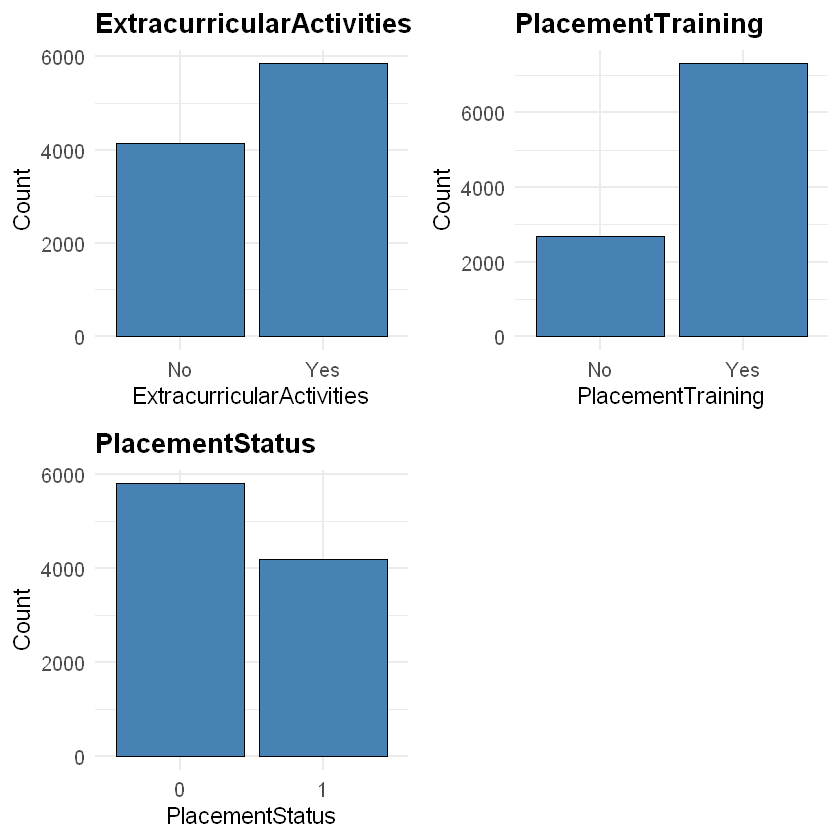

In [25]:
categorical_columns <- c("ExtracurricularActivities", "PlacementTraining","PlacementStatus")
plots <- list()

# Loop over each categorical variable to build a bar plot
for (cat_col in categorical_columns) {
  p <- ggplot(data = data, aes_string(x = cat_col)) +
    geom_bar(fill = "steelblue", color = "black") +
    labs(
      title = paste( cat_col),
      x = cat_col,
      y = "Count"
    ) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(size = 16, face = "bold"),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12)
    )
  plots[[cat_col]] <- p
}
grid.arrange(grobs = plots, ncol = 2)

- There are enough values in both the categorical predictor variables for each of their categories such that there is no reason to merge or drop come categories.
- For the response variable (PlacementStatus), there is no class imbalance, so no further tidying is required in this aspect.

##### **Check Distributional Skewness**

In [26]:
names(data)


[1] "CGPA"                      "Internships"              
 [3] "Projects"                  "Workshops_Certifications" 
 [5] "AptitudeTestScore"         "SoftSkillsRating"         
 [7] "ExtracurricularActivities" "PlacementTraining"        
 [9] "SSC_Marks"                 "HSC_Marks"                
[11] "PlacementStatus"

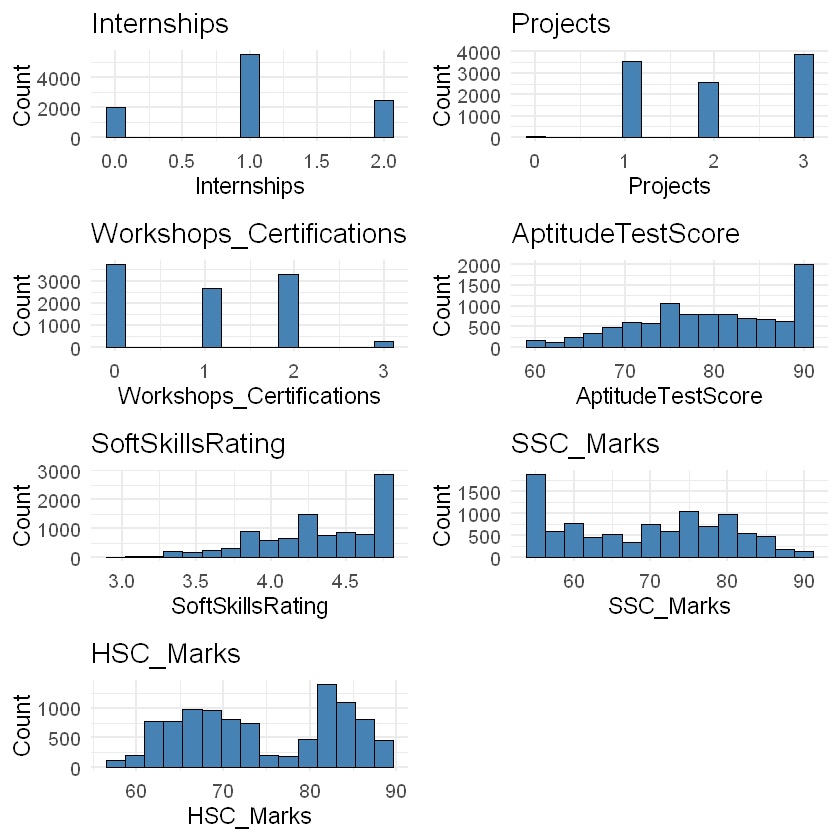

In [27]:
df_num <- c(
  "Internships", 
  "Projects", 
  "Workshops_Certifications",
  "AptitudeTestScore", 
  "SoftSkillsRating", 
  "SSC_Marks", 
  "HSC_Marks"
)

plots <- list()

for (colname in df_num) {
  p <- ggplot(data, aes_string(x = colname)) +
    geom_histogram(fill = "steelblue", color = "black", bins = 15) +  # No extra parentheses here
    labs(
      title = paste( colname),
      x = colname,
      y = "Count"
    ) +
    theme_minimal(base_size = 14)
  plots[[colname]] <- p
}

# Arrange all plots in a grid (2 columns, for example)
grid.arrange(grobs = plots, ncol = 2)


**Note: the number of students with Wrokshaops_Certifications experience = 3 and Project experience = 0 are clearly relatively low compared to other categories. So we check it here. The rest of the plots are looking fine right now.**

In [28]:
print(paste("The Number of Students who have Workshop Experience = 3:", 
            sum(data$Workshops_Certifications == "3")))

print(paste("The Number of Students who have Workshop Experience = 2:", 
            sum(data$Workshops_Certifications == "2")))

print(paste("---------------------------------------------------------------"))

print(paste("The Number of Students who have Project number = 1:", 
            sum(data$Projects == "1")))

print(paste("The Number of Students who have Project number = 0:", 
            sum(data$Projects == "0")))

[1] "The Number of Students who have Workshop Experience = 3: 284"
[1] "The Number of Students who have Workshop Experience = 2: 3303"
[1] "---------------------------------------------------------------"
[1] "The Number of Students who have Project number = 1: 3547"
[1] "The Number of Students who have Project number = 0: 30"


**Since there're clearly relative less people with workshop experience = 3 and Project experience = 0, so we will first merge them with the clostest category for now**. 

In [ ]:
#Pre-process Workshops
data <- data %>%
  mutate(
    Workshops_Certifications = as_factor(Workshops_Certifications),
    Workshops_Certifications = fct_collapse(
      Workshops_Certifications,
      "2+" = c("2", "3")
    )
  )
#Pre-process Projects
data <- data %>%
  mutate(
    Projects = as_factor(Projects),
    Projects = fct_collapse(
      Projects,
      "1-" = c("0", "1")
    )
  )

head(data, 3)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.5,1,1-,1,65,4.4,No,No,61,79,0
8.9,0,3,2+,90,4.0,Yes,Yes,78,82,1
7.3,1,2,2+,82,4.8,Yes,No,79,80,0


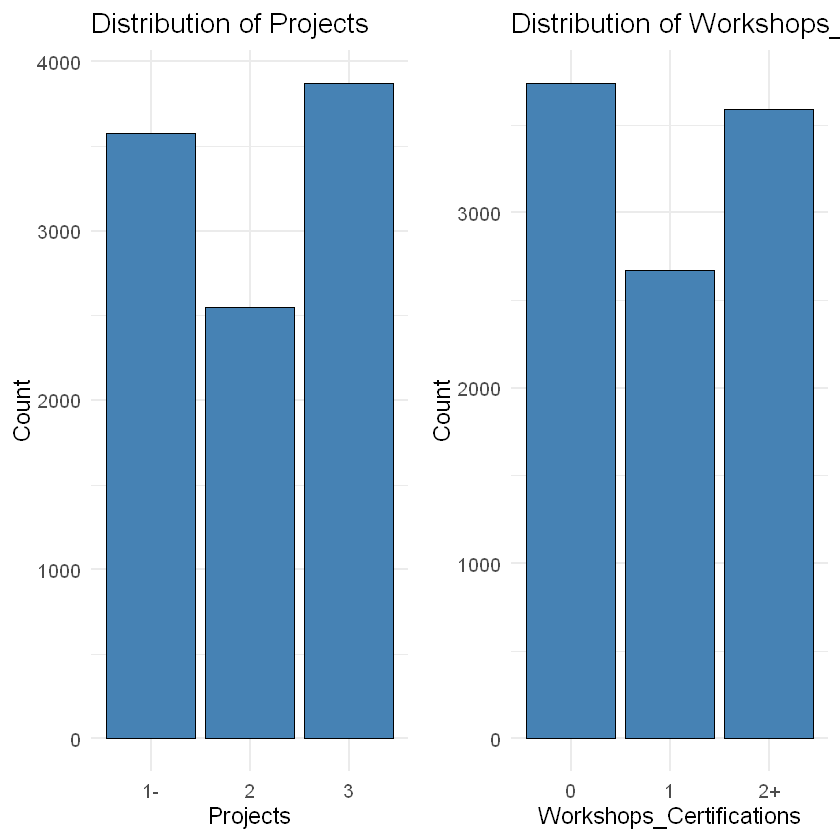

In [32]:
df_num <- c("Projects", "Workshops_Certifications")

plots <- list()

for (colname in df_num) {
  # Convert column to factor if it's not numeric
  if (!is.numeric(data[[colname]])) {
    data[[colname]] <- as.factor(data[[colname]])
  }

  p <- ggplot(data, aes_string(x = colname)) +
    geom_bar(fill = "steelblue", color = "black") + 
    labs(
      title = paste("Distribution of", colname),
      x = colname,
      y = "Count"
    ) +
    theme_minimal(base_size = 14)
  plots[[colname]] <- p
}

# Arrange all plots in a grid (2 columns)
gridExtra::grid.arrange(grobs = plots, ncol = 2)


##### **Two Effective Visualizations**

##### **1.Comparison of various scores of students by placement status**
- We will create a boxplot of the numerical covariates (CGPA, HSC_Marks, SSC_Marks, AptitudeTestScore, SoftSkillsRating)
- This, notably, excludes 3 numerical columns: `Internships`, `Project`s and `Workshops/Certifications`. This is because these columns have only descretised values, which are 0, 1, 2 or 3. Hence, their range, standard deviation and mean would differ a lot from the other numerical variables and thus won't look well on a single plot. Maybe in the future, we could even convert these column into 'factor' type (categorical variables) if it leads to better prediction.
- For the visualisation now, we will scale CGPA and SoftSkillsRating to be on the same scale
  - We will multiply CGPA by 10 to shift its range from 0-10 to 0-100
   - We will multiply SoftSkillsRating by 20 to shift its range 0-5 to 0-100 <br> This is done so a good comparison can be made visually by just looking at the plot.

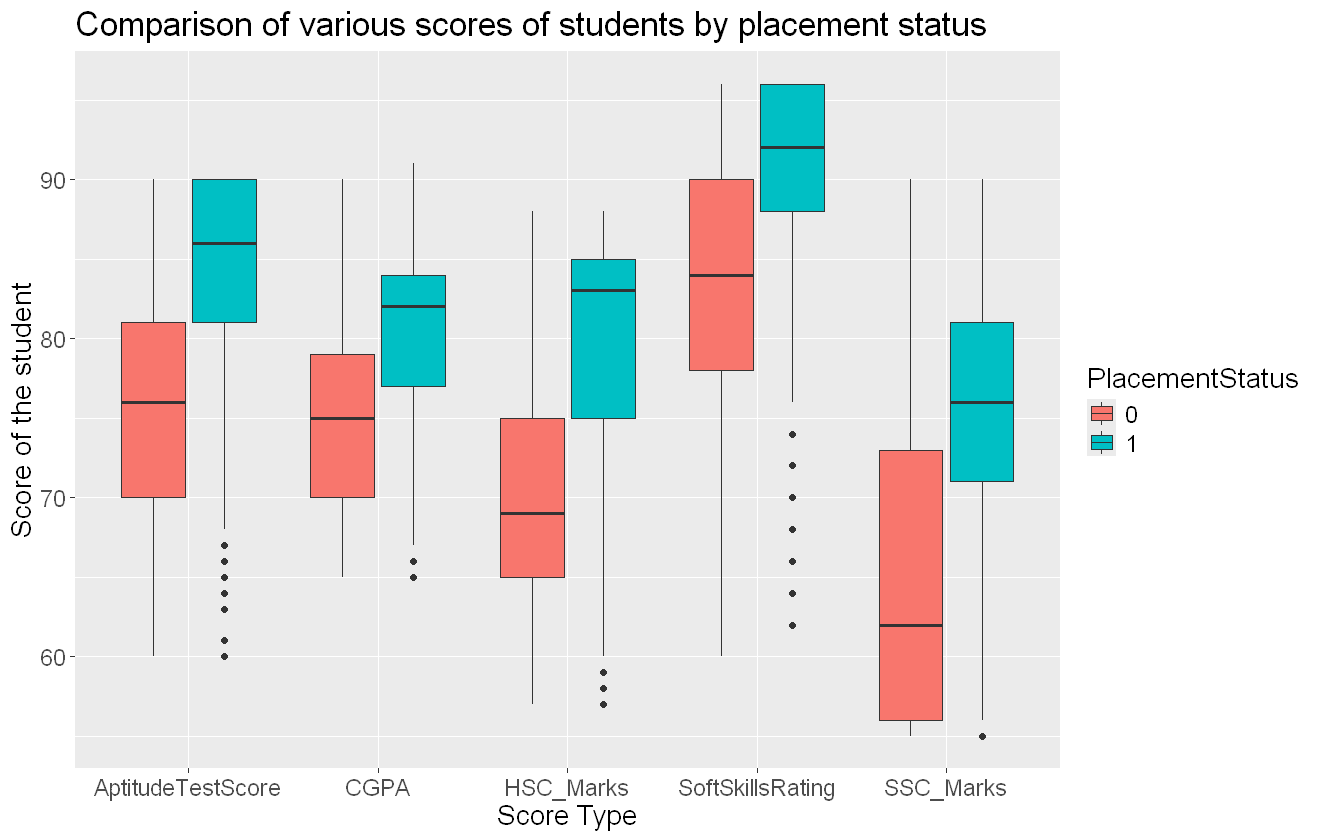

In [33]:
# Main developer: Ashmit Gupta

options(repr.plot.width = 11, repr.plot.height = 7)
marks_data <- data %>%
              mutate(CGPA = CGPA * 10, SoftSkillsRating = SoftSkillsRating * 20) %>% # Scaling CGPA and SoftSkillsRating to be from 1 to 100
              pivot_longer(cols = c(CGPA, HSC_Marks, SSC_Marks, AptitudeTestScore, SoftSkillsRating), 
                           names_to = "Score_Type", 
                           values_to = "Score")

marks_visualisation <- marks_data %>%
                       ggplot(aes(x = Score_Type, y = Score, fill = PlacementStatus)) +
                       geom_boxplot() +
                       ggtitle("Comparison of various scores of students by placement status") +
                       labs(x = "Score Type", y = "Score of the student") +
                       theme(text = element_text(size = 17))
                       
marks_visualisation

This graph is relevant to our research question as it shows the distribution of various possible predictors against the response variable (PlacementStatus). It shows that in general, the students who are placed tend to have a higher median score in the respective academic (or soft skill) category compared to the students who did not get placed.


##### **2. Check and Visualize Correlation between Features**

To detect whether there's a multicollinearlity issue in the independent variables, we examine it by both the correlation matrix and the variance inflation factor (VIF). 

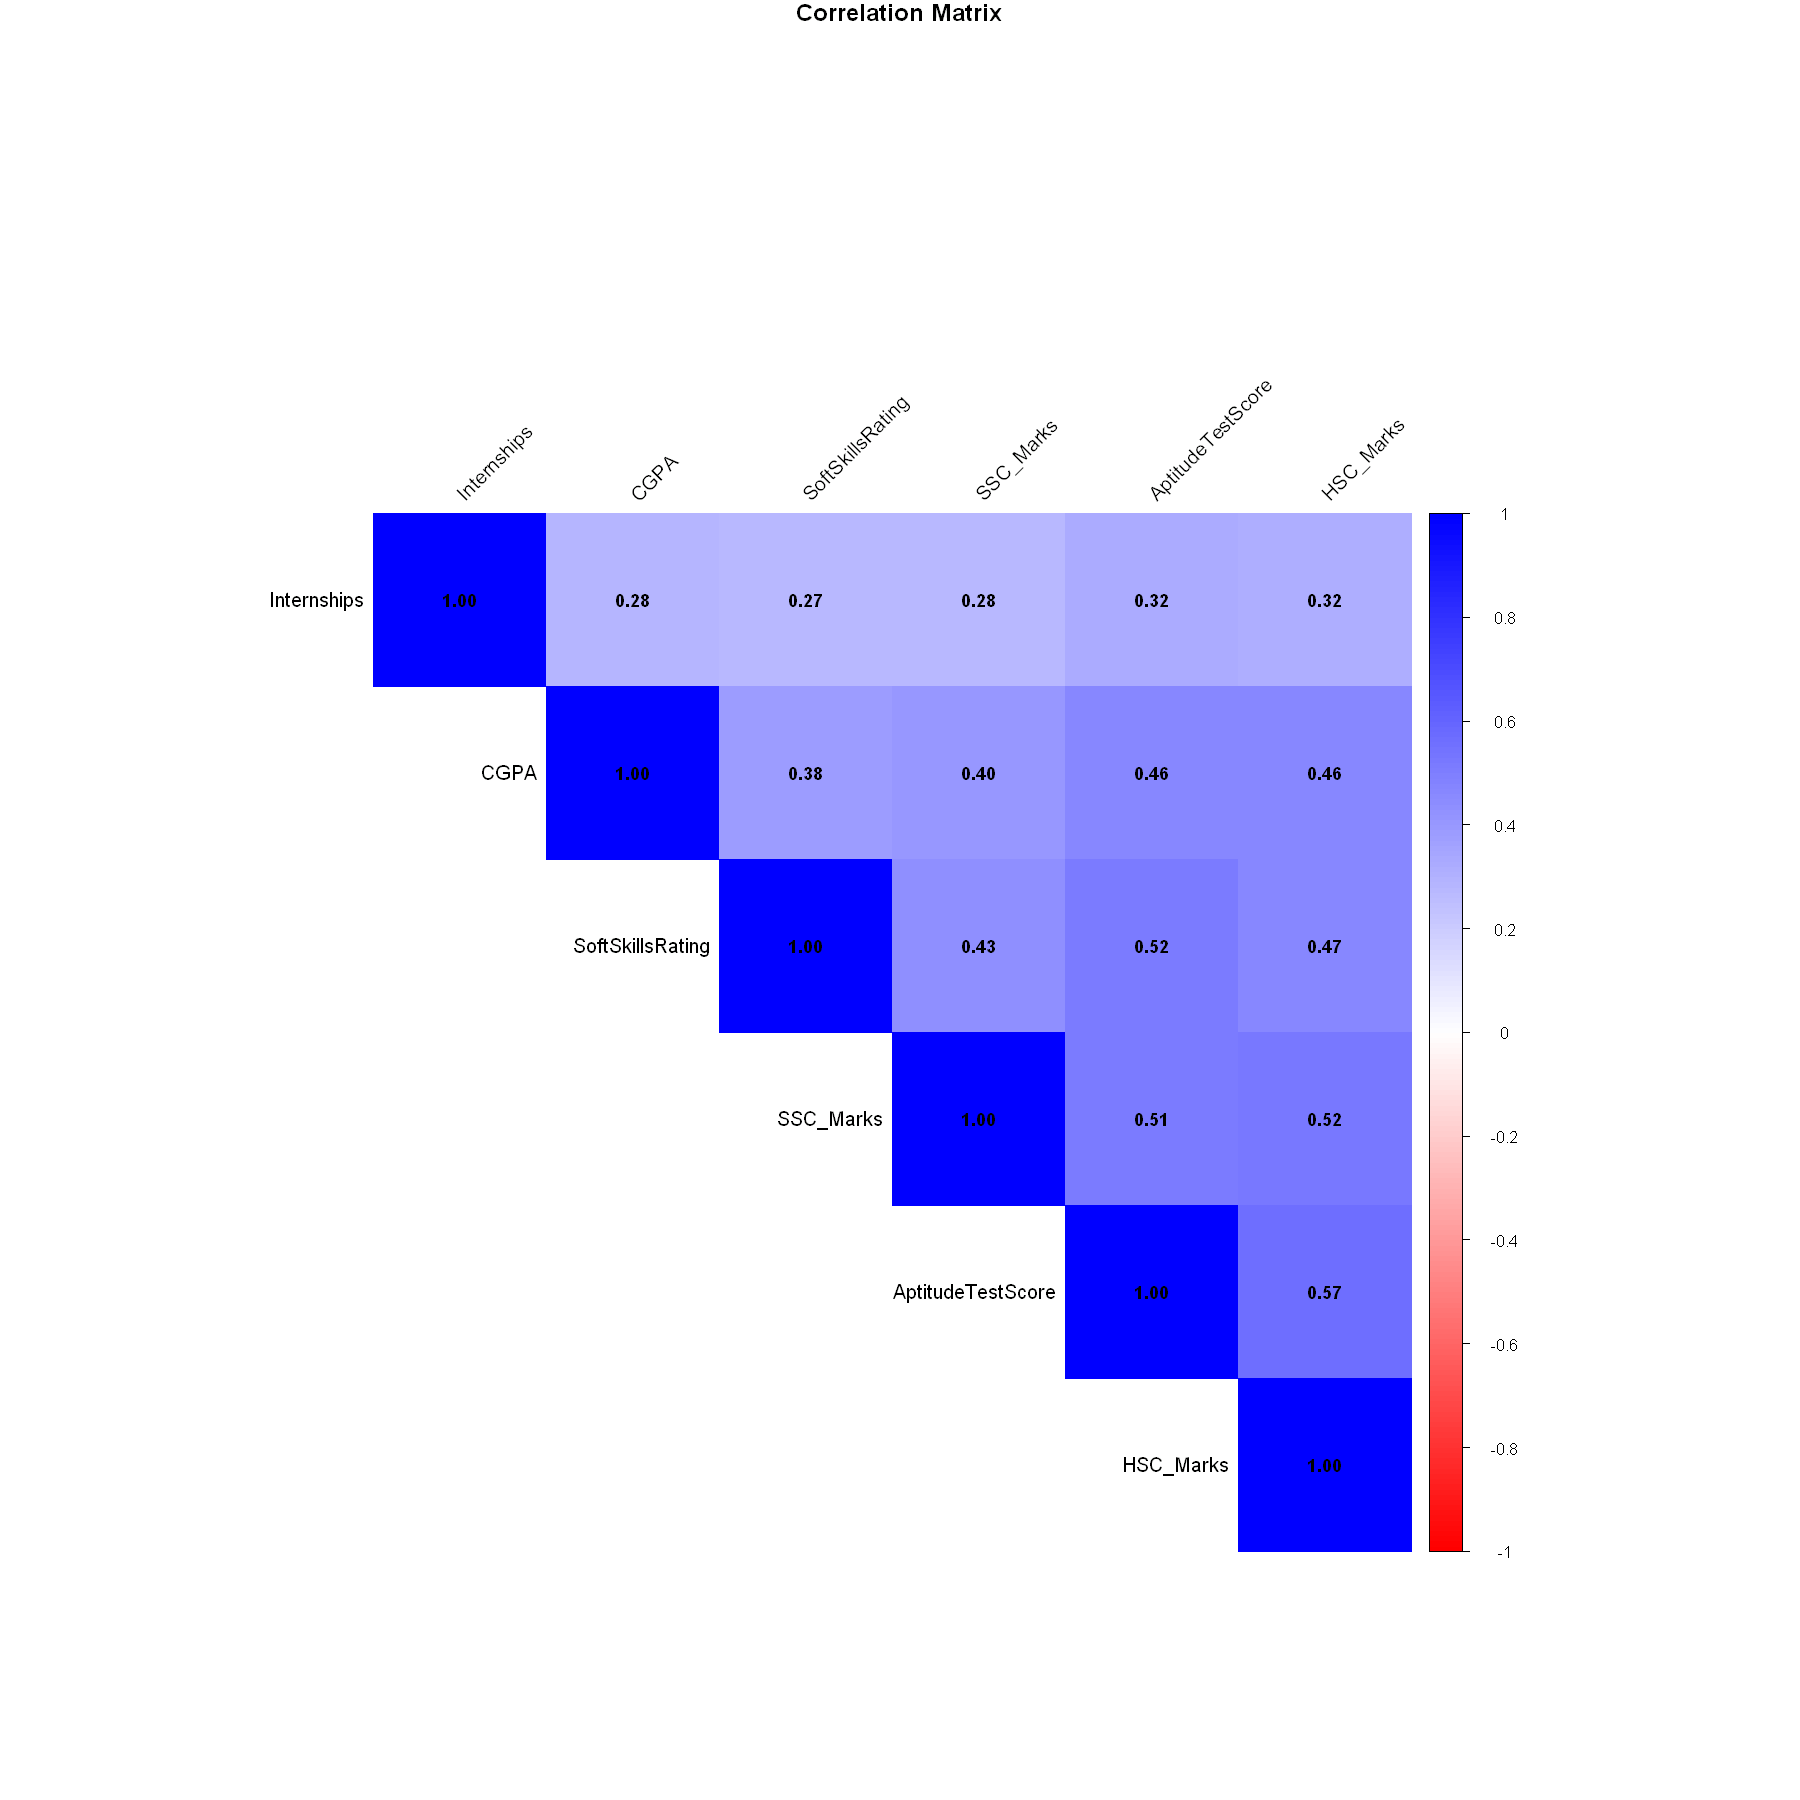

In [34]:

options(repr.plot.width = 15, repr.plot.height = 15)

numeric_data <- data %>% select_if(is.numeric)
cor_matrix <- cor(numeric_data, use = "complete.obs")

corrplot(cor_matrix,
         method = "color",
         type = "upper",
         order = "hclust",
         tl.col = "black",
         tl.srt = 45,
         col = colorRampPalette(c("red", "white", "blue"))(200),
         title = "Correlation Matrix",
         mar = c(0,0,1,0),
         addCoef.col = "black",
         number.cex = 0.9
)


The correlation matrix heatmap indicates all pairs in continuous variables have a positive relationship, moreover, the correlation coefficient between any two pairs are lower than 0.6, suggesting no strong correlation. Therefore, multicollinearlity issue is not concerning at this stage.

Next, we will use VIF to detect whether multicollinearlity issue exist among both continuous and categorical independent variables. 

,GVIF,Df,GVIF^(1/(2*Df))
CGPA,1.232387,1,1.110129
Internships,1.128324,1,1.062226
Projects,1.400640,2,1.087882
Workshops_Certifications,1.265626,2,1.060660
AptitudeTestScore,1.401241,1,1.183740
SoftSkillsRating,1.252753,1,1.119264
ExtracurricularActivities,1.284762,1,1.133473
PlacementTraining,1.031981,1,1.015865
SSC_Marks,1.316573,1,1.147420
HSC_Marks,1.462161,1,1.209198


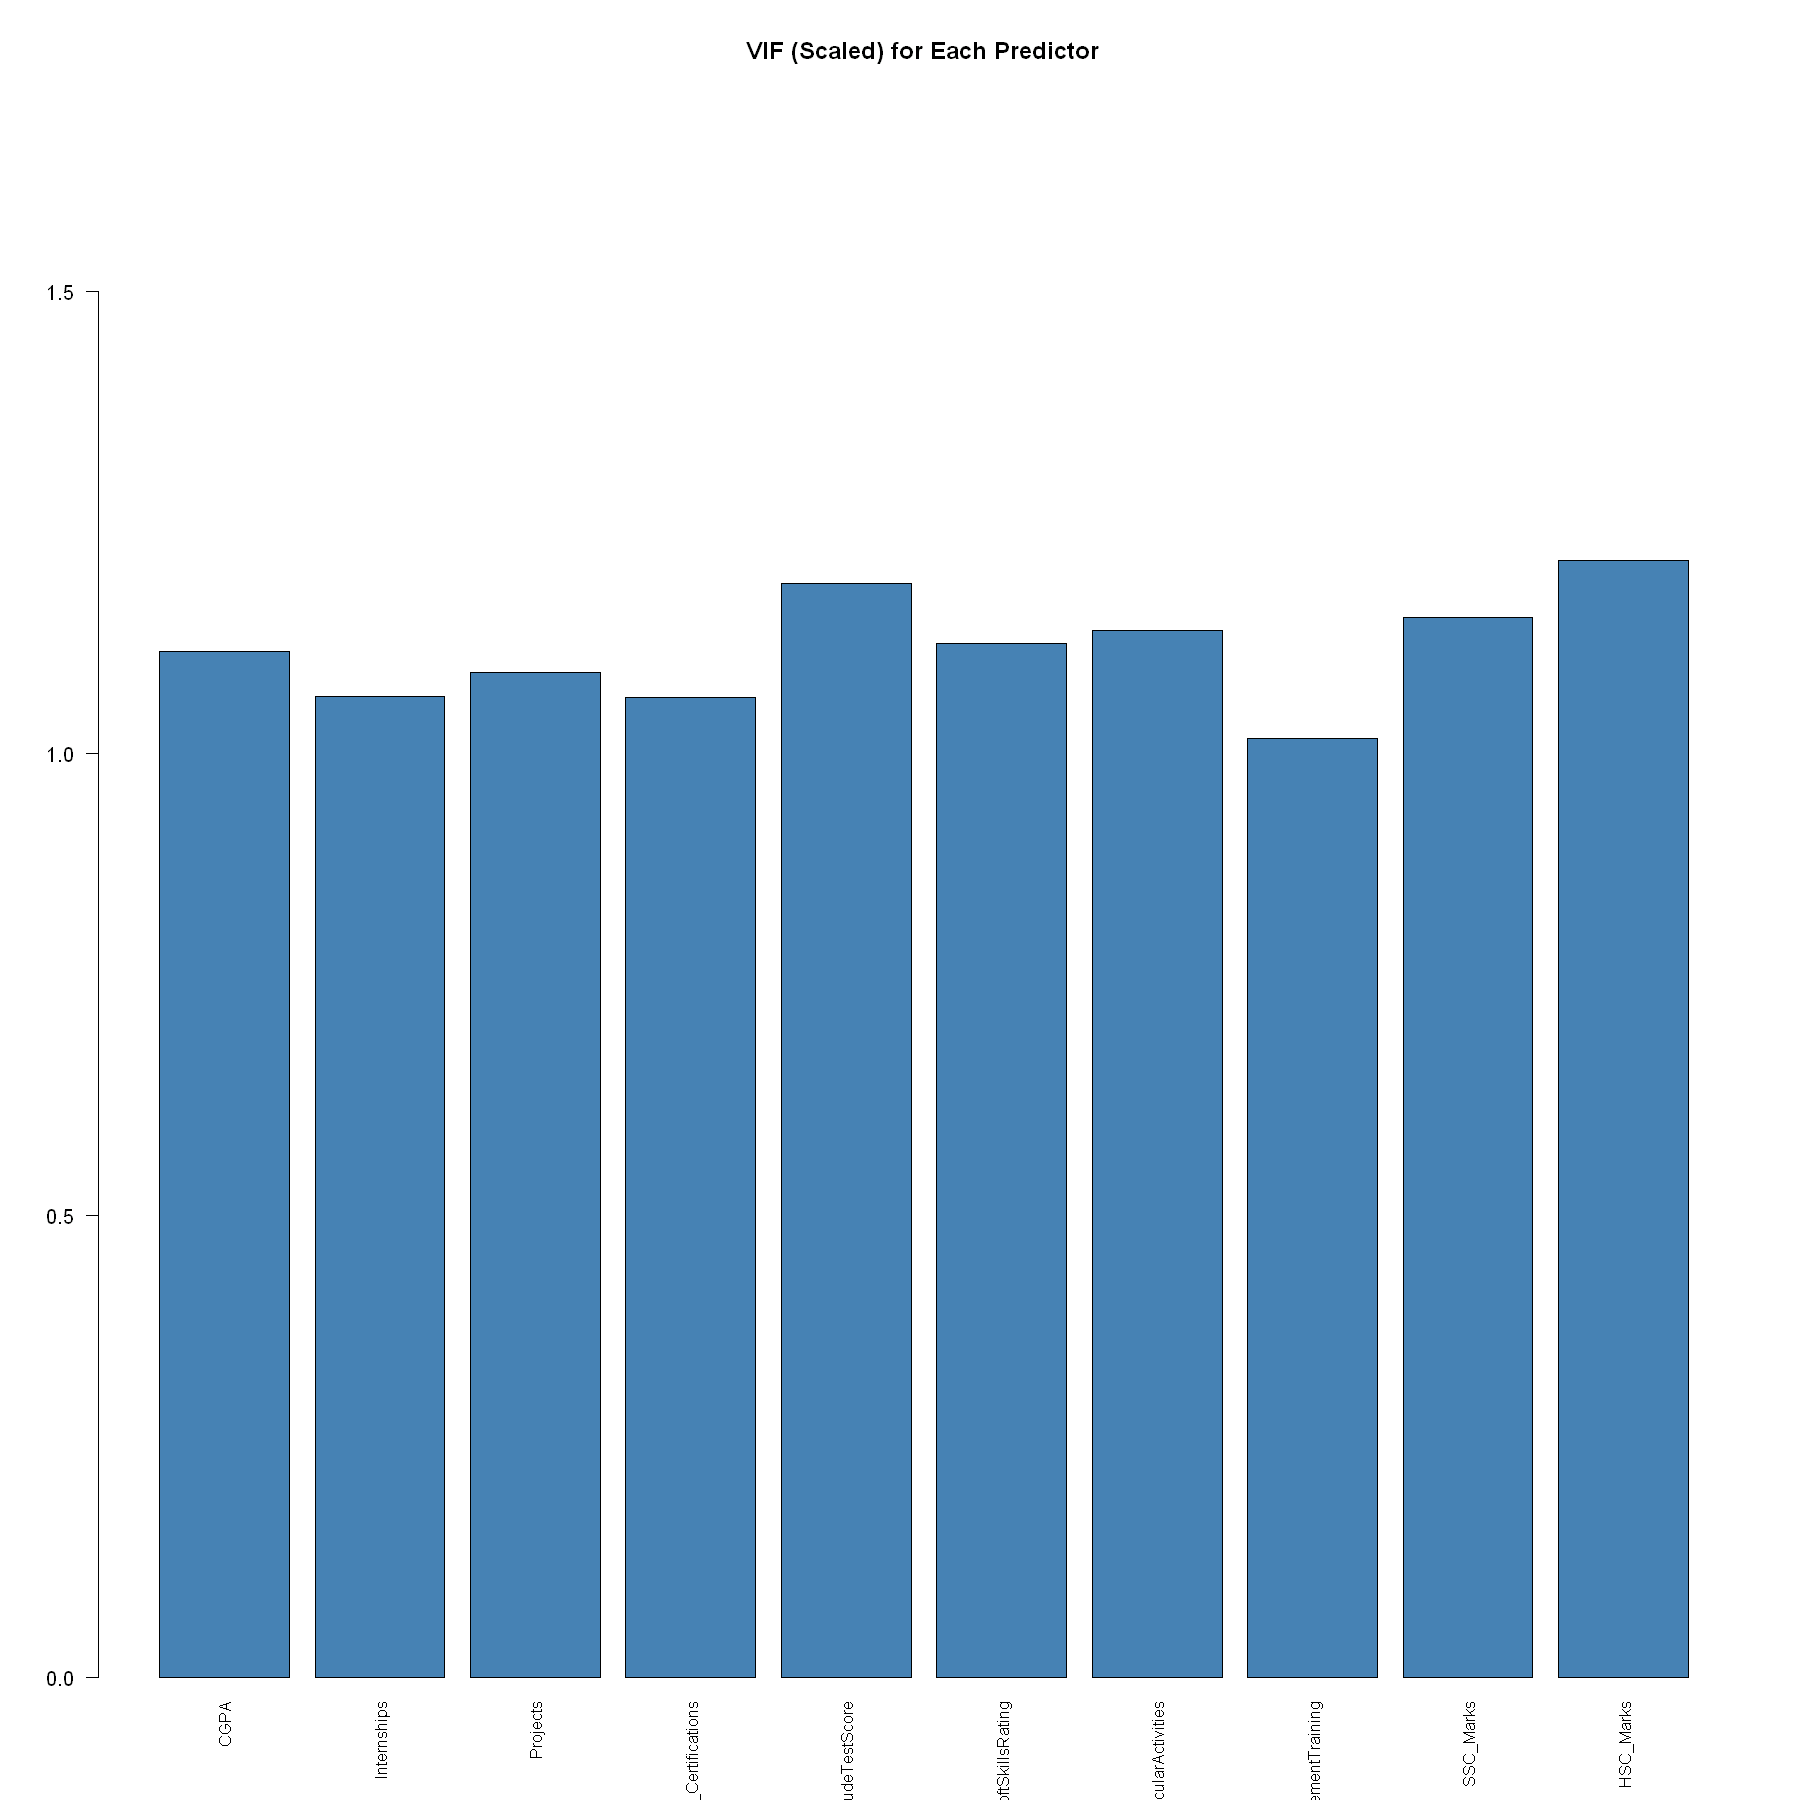

In [41]:

# 1) Prepare data for logistic regression

vif_data <- data %>%
  mutate(ExtracurricularActivities = if_else(ExtracurricularActivities == "Yes", 1, 0),
         PlacementTraining  = if_else(PlacementTraining  == "Yes", 1, 0))

# 2) Fit logistic model
model_vif <- glm(PlacementStatus ~ ., data = vif_data, family = "binomial")

# 3) Compute VIF
vif_res <- vif(model_vif)

vif_res

# 4) Extract the scaled GVIF if it's a matrix
if (is.matrix(vif_res)) {
  scaled_vif <- vif_res[, "GVIF^(1/(2*Df))"]
  # Preserve the row names as variable names
  names(scaled_vif) <- rownames(vif_res)
} else {
  # If vif_res is already a named vector (no factors), just use it
  scaled_vif <- vif_res
}

# 5) Make a barplot with one bar per predictor
barplot(
  scaled_vif,
  main      = "VIF (Scaled) for Each Predictor",
  names.arg = names(scaled_vif),
  las       = 2,                         
  cex.names = 0.8,                      
  col       = "steelblue",
  ylim      = c(0, max(scaled_vif) + 0.5)
)


The VIF value for each variable are all just slightly higher than 1, suggesting a low correlation between predictor variables based on the rules of thumb of VIF (GVIF ~= 1 indicating little to no multicollinearity). 

This is a more formal way to check and visualize the result concluded by correlation matrix, Generalized VIF suggests multicollinearlity issue is not concerning at this stage.

### **c) Methods: Plan**

#### **Method Used and Justifications**
For this prediction assignment, we propose using **Logistic Regression** to model and analyze the relationship between students' various measurements and their placement status.

#### Why is this method appropriate?
**Logistic Regression** is well-suited for binary classification problems because it models  the log-odds of the outcome as a linear function of explanatory variables. This allows us to quantify the **strength of association** between each explanatory variables and the likelihood of being placed for a job.

Also, it is easy to implement and interpret. The coefficients provide direct insight into how each covariate affects the log-odds of being placed or not, and p-values and confidence intervals (CIs) for the model coefficients are straightforward to generate. This is particularly valuable when I need to explain the model's decisions to non-technical stakeholders.

##### Which assumptions are required to apply the method selected?
* **Independence of Observations**: Each observation should be independent of the others.
* **Binary Response**: The response variable is binary.
* **Sample Size**: The sample size is large enough (which is satisfied in our case).
* **Linearity**: There should be a linear relationship between the independent variables (explanatory) and the log odds of the dependent variable (response).
* **Multicollinearity**: After data cleaning, there should be little or no multicollinearity among the independent variables.

##### Potential Limitations or Weaknesses of the Method Selected
* **Model Simplicity**: While logistic regression is straightforward, it may not capture complex non-linear relationships or interactions among variables as effectively as more advanced methods. Although it offers great interpretability, it might not provide the highest predictive accuracy compared to more complex models.
* **Outliers and Class Imbalance**: Logistic Regression is sensitive to outliers in the covariate space, which can affect the estimated coefficients and potentially skew the model's performance. Additionally, imbalanced classes may affect model performance if not addressed with appropriate techniques.


#### **Feature Selection**

For predictive modeling best practices, we will split the data and do cross-validation to avoid overfitting and to better estimate out-of-sample performance.

In [42]:
# 1) Split data into train & test sets
set.seed(123)  # for reproducibility
train_index <- sample(seq_len(nrow(data)), size = 0.7 * nrow(data))
train_data  <- data[train_index, ]
test_data   <- data[-train_index, ]

head(train_data)

CGPA,Internships,Projects,Workshops_Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
7.9,0,1-,0,64,4.1,Yes,Yes,63,67,0
8.2,2,3,2+,87,4.8,Yes,Yes,77,86,1
7.3,0,1-,0,72,4.3,No,No,55,68,0
6.8,1,1-,1,84,4.2,No,No,55,69,0
7.3,0,1-,1,74,3.8,No,Yes,60,65,0
7.9,0,2,0,75,4.3,No,No,79,63,0


In [43]:
# 2) Define a trainControl() object for k-fold CV
train_control <- trainControl(
  method = "cv",         # k-fold CV
  number = 10,           # for 10-fold
  savePredictions = TRUE
)

In [44]:
#3) Fit a model and do feature selection 
model_cv <- train(
  PlacementStatus ~ .,  
  data       = train_data,
  method     = "glmStepAIC",  # stepwise logistic
  family     = binomial,
  trControl  = train_control,
  trace      = FALSE  # suppress stepwise AIC output
)

#model_cv
summary(model_cv$finalModel)

finalmodel1 <- model_cv$finalModel

#WE TRAIN


Call:
NULL

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  -16.440476   0.657634 -24.999  < 2e-16 ***
CGPA                           0.352759   0.059739   5.905 3.53e-09 ***
Projects2                      0.165889   0.088103   1.883   0.0597 .  
Projects3                      0.549776   0.090872   6.050 1.45e-09 ***
Workshops_Certifications1     -0.375203   0.086352  -4.345 1.39e-05 ***
`Workshops_Certifications2+`   0.347914   0.080981   4.296 1.74e-05 ***
AptitudeTestScore              0.068917   0.005680  12.133  < 2e-16 ***
SoftSkillsRating               0.621913   0.100498   6.188 6.08e-10 ***
ExtracurricularActivitiesYes   0.793732   0.081300   9.763  < 2e-16 ***
PlacementTrainingYes           0.957316   0.087239  10.973  < 2e-16 ***
SSC_Marks                      0.025327   0.003826   6.620 3.58e-11 ***
HSC_Marks                      0.023177   0.004557   5.086 3.65e-07 ***
---
Signif. codes:  0 '***' 0.001 '**

**How the test data created and used :**

* We manually split the train and test data. Then we performed a 10-fold-cros-validation on the training data only, within each fold, we run a stepwise logistic regression to choose covariates (based on AIC). After that, aggregating performance across the 10 folds to decide the best final overall model.
* Note that we kept the test data locked and it wasn't used in fitting or selecting the model, only for final evaluation.

**A brief Interpretation of the results:**

Note that in the summary output of the logistic regression model, the covariate **Internships** was not selected (dropped) by StepAIC, indicating that it may have little predictive effect on the response variable.


maybe adding things here

**Performing a careful model assessment and showing visualizations**

1. 

In [ ]:
# Prediction and Reporting 

test_probs  <- predict(model_cv, newdata = test_data, type = "prob")[, "1"]
test_class   <- ifelse(test_probs > 0.5, "1", "0")

# Convert predictions and test outcomes to factors (0/1) for confusionMatrix
test_pred_factor <- factor(test_class, levels = c(0,1))
test_out_factor  <- factor(test_data$PlacementStatus, levels = c(0,1))

# -----------------------------------------------------
# Evaluate performance
# -----------------------------------------------------
conf_mat <- confusionMatrix(test_pred_factor, test_out_factor)
conf_mat


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1460  314
         1  291  935
                                          
               Accuracy : 0.7983          
                 95% CI : (0.7835, 0.8126)
    No Information Rate : 0.5837          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5839          
                                          
 Mcnemar's Test P-Value : 0.3711          
                                          
            Sensitivity : 0.8338          
            Specificity : 0.7486          
         Pos Pred Value : 0.8230          
         Neg Pred Value : 0.7626          
             Prevalence : 0.5837          
         Detection Rate : 0.4867          
   Detection Prevalence : 0.5913          
      Balanced Accuracy : 0.7912          
                                          
       'Positive' Class : 0               
                        

Based on the confusion matrix and accompanying statistics, the logistic regression model achieves approximately **79.83%** accuracy, meaning it correctly distinguishes “Placed” versus “Not Placed” students most of the time. Its Sensitivity (about **83%**) implies that the model accurately identifies a high proportion of students who are truly placed, and a Specificity near **75%** indicates it does a fair job of minimizing false positives. Overall, these metrics suggest a reasonably balanced performance in predicting placement outcomes, though there may still be room for fine‐tuning or additional feature engineering to further improve results.

2. Check ROC

Setting direction: controls < cases



Area under the curve: 0.8769

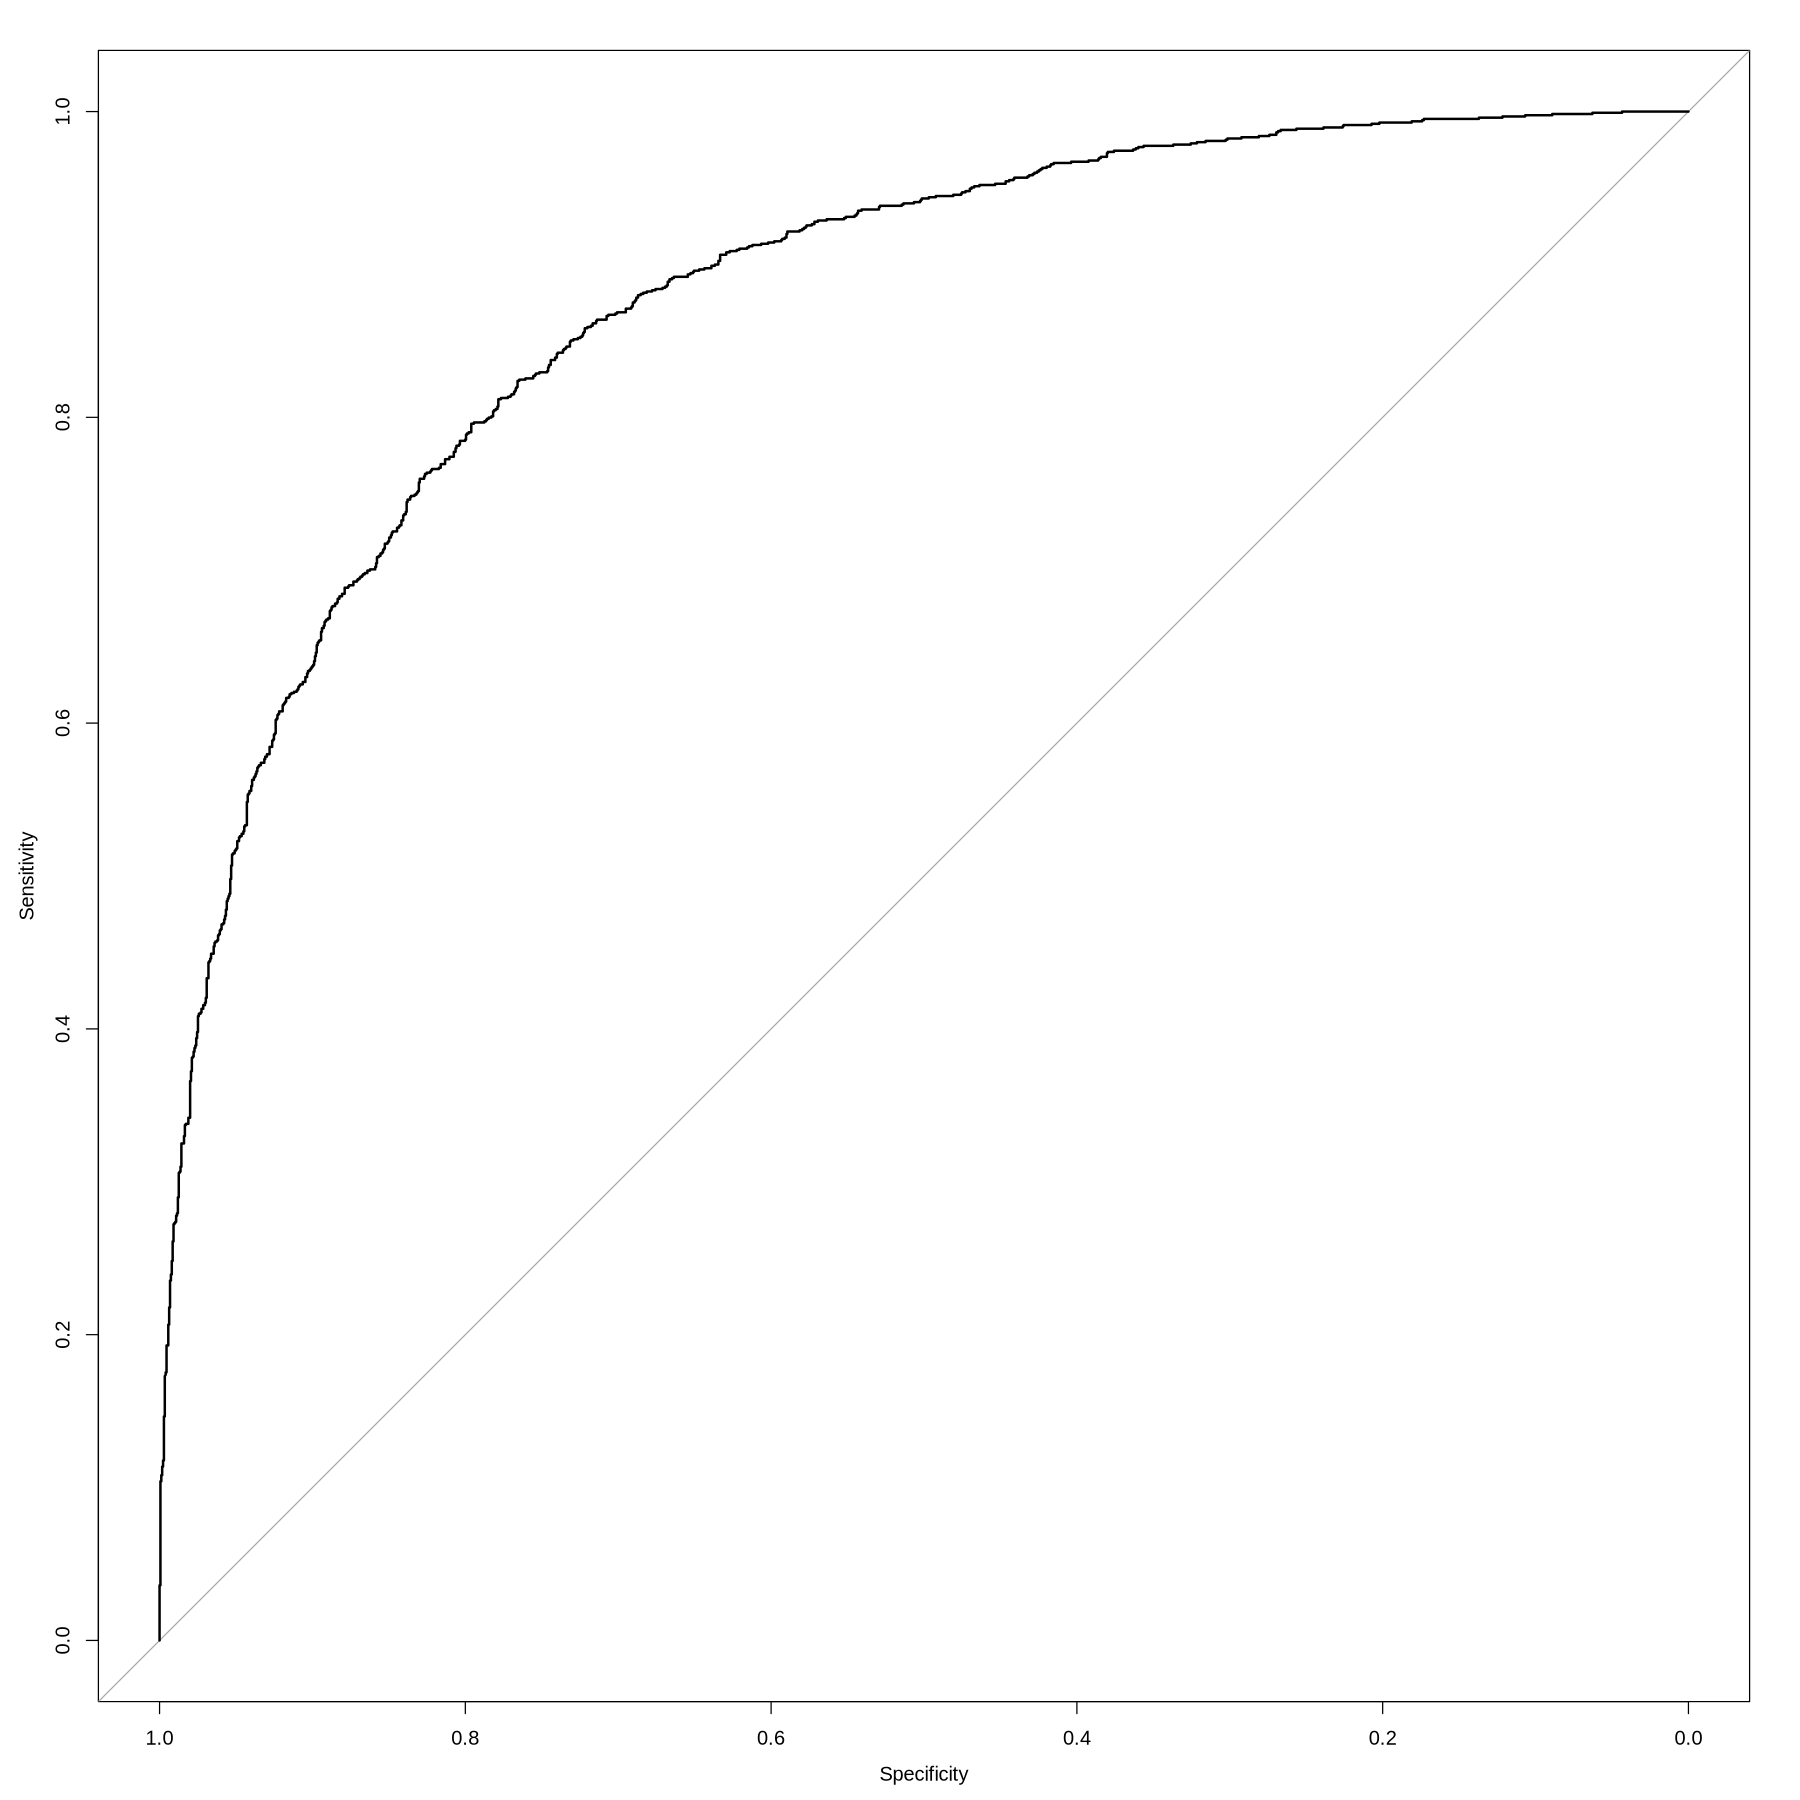

In [117]:
roc_obj <- roc(response = test_data$PlacementStatus,
               predictor = test_probs,
               levels = c("0","1"))
auc_val <- auc(roc_obj)
plot(roc_obj)


auc_val #area under the ROC Curve


This ROC curve shows how well our model can tell the difference between placed and not placed students. With an AUC (Area Under the Curve) of 0.877, the curve hugs the top-left corner, meaning the model performs very well across different threshold values. In simple terms, it’s good at ranking students by their likelihood of getting placed—even beyond just a 0.5 cut-off.

3. Overfitting/Underfitting Check

In [118]:
cv_results <- model_cv$resample
mean_cv_accuracy <- mean(cv_results$Accuracy)

test_probs <- predict(model_cv, newdata = test_data, type = "prob")[, "1"]
test_pred <- ifelse(test_probs > 0.5, 1, 0)
test_pred_factor <- factor(test_pred, levels = c(0, 1))
test_out_factor <- factor(test_data$PlacementStatus, levels = c(0, 1))

conf_mat <- confusionMatrix(test_pred_factor, test_out_factor)
test_accuracy <- conf_mat$overall["Accuracy"]

cat("Mean CV Accuracy (Train Set):", round(mean_cv_accuracy, 4), "\n")
cat("Test Set Accuracy:", round(test_accuracy, 4), "\n")

Mean CV Accuracy (Train Set): 0.7994 
Test Set Accuracy: 0.7983 


The test set accuracy of 79.83% aligns closely with the cross-validated training accuracy of 79.94%, as shown. The near-identical values is a great sign, it means the model is consistent and not just memorizing the training data. It performs similarly on data it hasn’t seen before.

- Plot to visualize Performance Difference

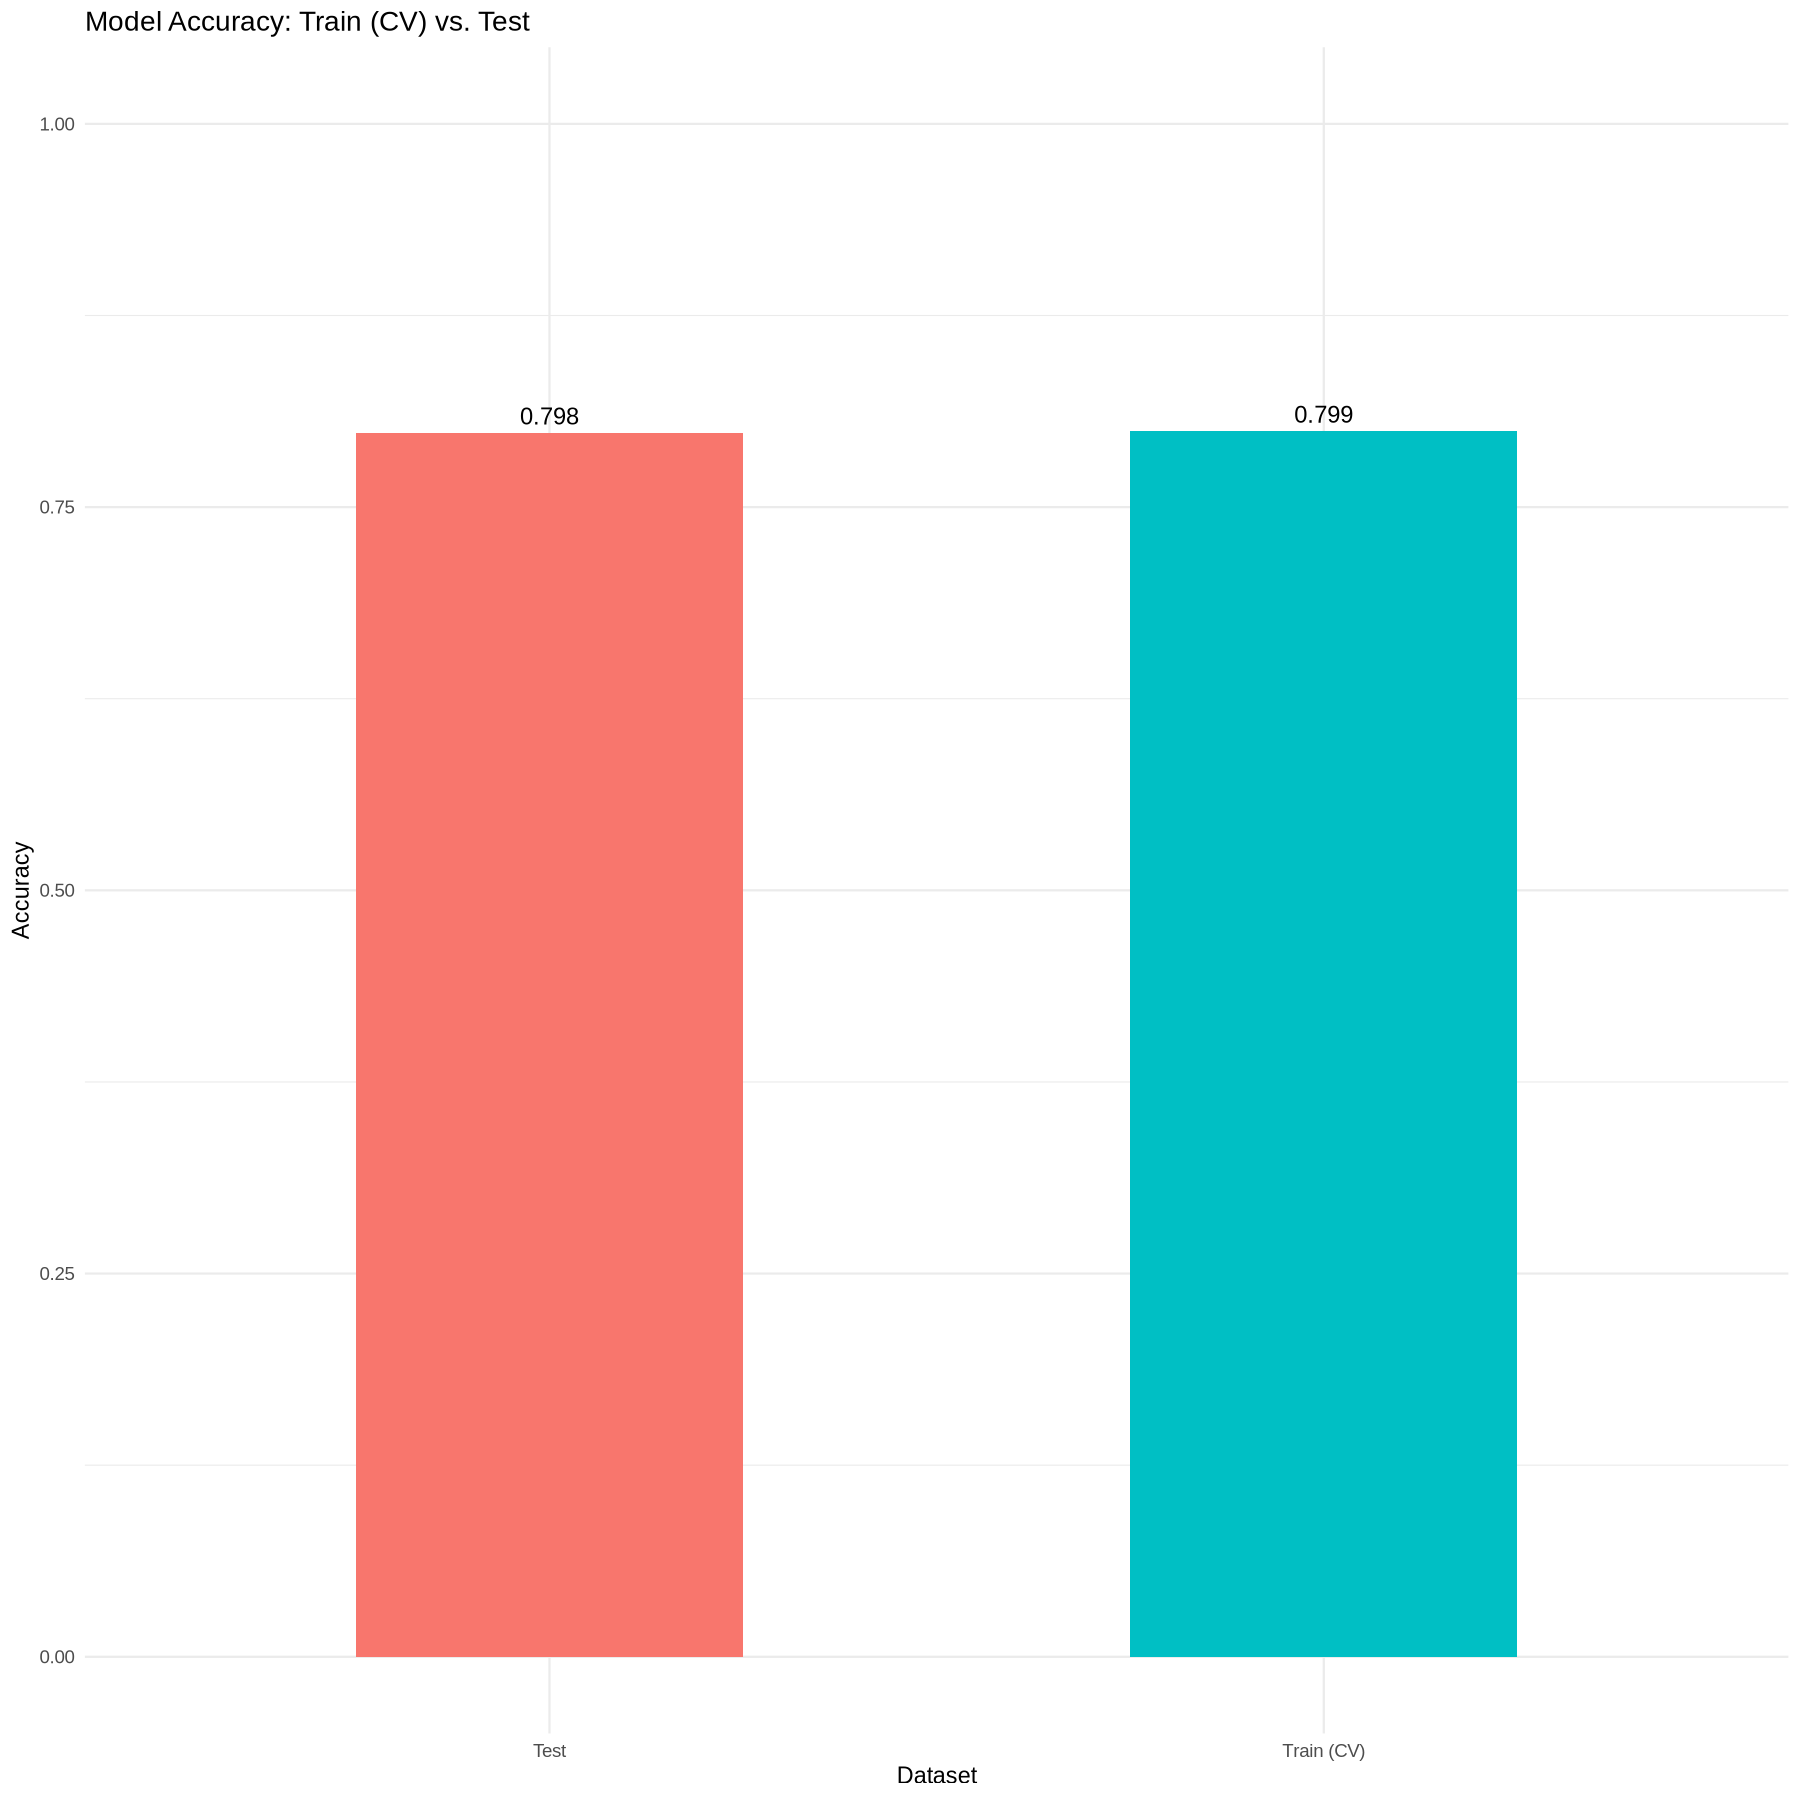

In [119]:
# Barplot comparing train (CV) vs. test accuracy
accuracy_df <- data.frame(
  Dataset = c("Train (CV)", "Test"),
  Accuracy = c(mean_cv_accuracy, test_accuracy)
)

ggplot(accuracy_df, aes(x = Dataset, y = Accuracy, fill = Dataset)) +
  geom_col(width = 0.5) +
  ylim(0, 1) +
  geom_text(aes(label = round(Accuracy, 3)), vjust = -0.5, size = 5) +
  labs(title = "Model Accuracy: Train (CV) vs. Test",
       y = "Accuracy") +
  theme_minimal(base_size = 14) +
  theme(legend.position = "none")

This bar chart visually compares accuracy on the training data (via cross-validation) and the test data. The bars are nearly the same height (both around 79.8%), confirming that the model generalizes well. There’s no sign of overfitting (doing well on training but badly on test), and no underfitting either (doing badly on both). This adds confidence that the model is reliable.

# 3. Discussion


Our primary goal was to evaluate how well a logistic regression model can predict student placement status using academic scores, co-curricular activities, and training indicators. The final model achieved a test set accuracy of 79.83% and a nearly identical cross-validated (CV) training accuracy of 79.94%, suggesting excellent generalization performance with no evidence of overfitting or underfitting. This is further supported by the ROC AUC of 0.877, indicating strong discriminative power.

**Key Findings & Implications**
The most impactful predictors based on model coefficients include:

- PlacementTrainingYes (β = 0.96) and ExtracurricularActivitiesYes (β = 0.79), highlighting the real-world value of training and non-academic development.

- AptitudeTestScore (β = 0.07), SoftSkillsRating (β = 0.62), and CGPA (β = 0.35) are all statistically significant (p < 0.001), aligning with expectations that stronger academic and aptitude performance increases placement likelihood.

- Participation in Projects (especially Projects3, β = 0.55) and Workshops_Certifications also show meaningful positive associations.

These findings imply that holistic student development, not just academic achievement, plays a major role in employability. Institutions may leverage this insight to encourage project-based learning and soft skill training.
However, while the model predicts well, it is essential to recognize that these relationships are associational, not causal. For instance, students who undergo placement training may already be more motivated or better prepared. Thus, we cannot conclude that training *causes* placement success.

**Expectations vs. Results**
The results closely align with expectations: academic performance (CGPA), aptitude (AptitudeTestScore), and interpersonal ability (SoftSkillsRating) were anticipated to be strong predictors. Notably, PlacementTraining emerged as the most influential categorical variable, reinforcing the importance of structured preparation programs.

Interestingly, Internships was dropped during stepwise feature selection due to a lack of statistical contribution (∆AIC ≈ -25). This may reflect low variability or limited effect in this dataset.

**Model Improvement Opportunities**
While performance metrics are strong, the model could be refined in the following ways:

- The right-skewed AptitudeTestScore, especially a peak at 90, suggests potential bias. Binning or transforming this variable may improve fit and meet linearity assumptions.

- Testing non-linear models could help capture interactions and non-additive effects that logistic regression may miss.

- The current probability threshold (0.5) could be adjusted to better balance sensitivity (83%) and specificity (75%), depending on whether minimizing false positives or false negatives is more important to the people interested.

**Future Research Directions**
- Use causal inference techniques to better understand the true effect of factors like PlacementTraining.

- Include institution-level data (e.g., college rank, company connections) to expand the model’s generalizability.

- Investigate interaction effects, such as whether the benefit of soft skills or certifications is amplified when paired with training.

# 4. References
- Dataset has downloaded from Kaggle (https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data)
- All the information (like data description, number of variables, number of observations, variable name, variable type and variable description) in the main 'Data Description' section has been adapted from https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset/data
- Kim, J., Oh, J., & Rajaguru, Y. (2022). Job-seeking anxiety and job preparation behavior of undergraduate students. Healthcare, 10(2), 288. https://doi.org/10.3390/healthcare10020288
- Strawberry Seed Consulting. (2015, March 2). 3 reasons why you can’t find your dream job [Illustration]. https://strawberryseed.com.au/find-your-dream-job/